In [ ]:

!pip install -q pycaret
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install haversine
!pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/

In [ ]:
from pycaret.regression import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import  StandardScaler,MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost
from scipy.stats import randint
from sklearn.metrics import mean_squared_log_error,silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from haversine import haversine
from sklearn.datasets import fetch_california_housing as fch

# 피처 엔지니어링

## 거리 변수 추가

- 위도와 경도를 활용한 파생변수 생성
    - 캘리포니아 주요 도시와 주요 해변의 좌표별 거리 칼럼을 추가
    - EDA 과정에서 해변에 근접할 수록 집값이 비싼것을 확인하여 새로운 피처를 추가함
    - 인구와 가격의 상관관계가 낮은 것을 확인하여 인구가 밀집된 도시와의 상관관계를 확인하고자 주요 도시와의 거리 변수 추가

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/sample_submission.csv')
sklearn_df = pd.DataFrame(fch()['data'], columns=fch()['feature_names'])
sklearn_df['MedHouseVal'] = fch()['target']
train["is_generated"] = True
test["is_generated"] = True
sklearn_df["is_generated"] = False
train_copy = pd.concat([train.drop('id',axis = 1),sklearn_df]).copy()
test_copy = test.copy().drop('id', axis=1)
df = pd.concat([train_copy, test_copy])

# 캘리포니아 주요 해변
coast = np.array([[32.664472968971786, -117.16139777220666],
         [33.20647603453836, -117.38308931734736],
         [33.77719697387153, -118.20238415808473],
         [34.46343131623148, -120.01447157053916],
         [35.42731619324845, -120.8819602254066],
         [35.9284107340049, -121.48920228383551],
         [36.982737132545495, -122.028973002425],
         [37.61147966825591, -122.49163361836126],
         [38.3559871217218, -123.06032062543764],
         [39.79260770260524, -123.82178288918176],
         [40.799744611668416, -124.18805587680554],
         [41.75588735544064, -124.19769463963775]])
city = np.array([[38.576931, -121.494949],
        [37.780080, -122.420160],
        [37.334789, -121.888138],
        [34.052235, -118.243683],
        [32.715759, -117.163818]])

def cluster_features_coast(df):
    for i, location in enumerate(coast):
        df[f'coast_{i}'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), location, unit='km'), axis=1)
    return df
def cluster_features_city(df):
    for i, location in enumerate(city):
        df[f'city_{i}'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), location, unit='km'), axis=1)
    return df
clu =cluster_features_coast(df)
clu = cluster_features_city(clu)

In [ ]:
clu.shape, clu.columns, display(clu.head(2))

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,is_generated,...,coast_7,coast_8,coast_9,coast_10,coast_11,city_0,city_1,city_2,city_3,city_4
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,True,...,396.861046,493.429155,663.833754,776.51509,871.600933,458.920195,409.411859,343.193147,182.746298,344.584492
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,True,...,163.540022,164.345947,255.398431,345.54448,424.358540,26.989529,145.685572,161.660497,580.385319,758.366057


((82536, 27),
 Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
        'Latitude', 'Longitude', 'MedHouseVal', 'is_generated', 'coast_0',
        'coast_1', 'coast_2', 'coast_3', 'coast_4', 'coast_5', 'coast_6',
        'coast_7', 'coast_8', 'coast_9', 'coast_10', 'coast_11', 'city_0',
        'city_1', 'city_2', 'city_3', 'city_4'],
       dtype='object'),
 None)

In [ ]:
test_clu = clu[ pd.isnull(clu['MedHouseVal']) ]
test_clu.drop('MedHouseVal',axis = 1, inplace = True)
train_clu = clu[ ~pd.isnull(clu['MedHouseVal']) ]
train_clu.shape, test_clu.shape

((57777, 27), (24759, 26))

In [ ]:
X = train_clu.drop('MedHouseVal', axis = 1)
y = train_clu[['MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## 선형회귀

In [ ]:
lr_model = LinearRegression() # 모델 생성
lr_model.fit(X_train, y_train) # 모델 학습
y_pred = lr_model.predict(X_test ) # 예측
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # 평가
print(rmse)
sub = lr_model.predict(test_clu)
submission['MedHouseVal'] = sub
submission.to_csv('LinearRegression_clu.csv',index = False)

0.6966274694116504


## CatBoost

### 모델 생성

In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 42)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = cat_model.predict(test_clu)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_clu.csv',index = False)

Learning rate set to 0.075028
0:	learn: 1.1076500	total: 65.5ms	remaining: 1m 5s
1:	learn: 1.0632751	total: 84.1ms	remaining: 42s
2:	learn: 1.0239733	total: 98.3ms	remaining: 32.7s
3:	learn: 0.9870471	total: 113ms	remaining: 28.1s
4:	learn: 0.9516856	total: 128ms	remaining: 25.4s
5:	learn: 0.9198523	total: 143ms	remaining: 23.7s
6:	learn: 0.8910478	total: 158ms	remaining: 22.3s
7:	learn: 0.8665273	total: 172ms	remaining: 21.4s
8:	learn: 0.8424554	total: 187ms	remaining: 20.6s
9:	learn: 0.8220991	total: 206ms	remaining: 20.4s
10:	learn: 0.8033634	total: 220ms	remaining: 19.8s
11:	learn: 0.7861677	total: 237ms	remaining: 19.5s
12:	learn: 0.7701023	total: 251ms	remaining: 19.1s
13:	learn: 0.7558938	total: 267ms	remaining: 18.8s
14:	learn: 0.7419255	total: 283ms	remaining: 18.6s
15:	learn: 0.7288059	total: 297ms	remaining: 18.3s
16:	learn: 0.7185366	total: 312ms	remaining: 18s
17:	learn: 0.7079249	total: 326ms	remaining: 17.8s
18:	learn: 0.6991120	total: 341ms	remaining: 17.6s
19:	learn: 0

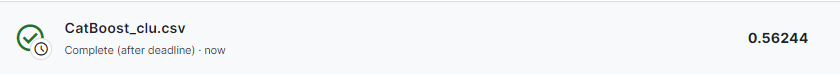

In [ ]:
pd.DataFrame(data = cat_model.feature_importances_.reshape((1,-1)), columns=X.columns)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,is_generated,coast_0,...,coast_7,coast_8,coast_9,coast_10,coast_11,city_0,city_1,city_2,city_3,city_4
0,34.832098,2.84951,2.181433,1.009246,1.168297,10.823049,4.151003,4.883186,0.836125,0.420972,...,4.32362,1.159253,0.299749,0.241986,0.660318,1.574535,1.376326,1.156575,2.603556,1.368793


- 새로 추가한 파생 변수들의 중요도가 높지는 않지만 의미는 있다고 판단

In [ ]:
cat_model = catboost.CatBoostRegressor(learning_rate = 0.01, depth = 9, l2_leaf_reg = 8, min_data_in_leaf=35, random_strength=0.63)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = cat_model.predict(test_clu)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_clu_param.csv',index = False)

0:	learn: 1.1504117	total: 105ms	remaining: 1m 44s
1:	learn: 1.1433830	total: 158ms	remaining: 1m 18s
2:	learn: 1.1363320	total: 208ms	remaining: 1m 9s
3:	learn: 1.1295528	total: 258ms	remaining: 1m 4s
4:	learn: 1.1226170	total: 311ms	remaining: 1m 1s
5:	learn: 1.1158809	total: 362ms	remaining: 1m
6:	learn: 1.1090889	total: 430ms	remaining: 1m
7:	learn: 1.1025498	total: 481ms	remaining: 59.6s
8:	learn: 1.0959428	total: 534ms	remaining: 58.8s
9:	learn: 1.0894133	total: 584ms	remaining: 57.9s
10:	learn: 1.0830005	total: 633ms	remaining: 56.9s
11:	learn: 1.0765971	total: 687ms	remaining: 56.5s
12:	learn: 1.0703287	total: 739ms	remaining: 56.1s
13:	learn: 1.0641461	total: 788ms	remaining: 55.5s
14:	learn: 1.0581342	total: 835ms	remaining: 54.8s
15:	learn: 1.0519668	total: 882ms	remaining: 54.3s
16:	learn: 1.0460493	total: 930ms	remaining: 53.8s
17:	learn: 1.0401666	total: 984ms	remaining: 53.7s
18:	learn: 1.0342964	total: 1.03s	remaining: 53.5s
19:	learn: 1.0284811	total: 1.08s	remaining: 

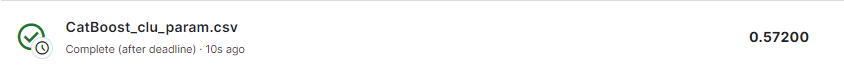

In [ ]:
pd.DataFrame(data = cat_model.feature_importances_.reshape((1,-1)), columns=X.columns)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,is_generated,coast_0,...,coast_7,coast_8,coast_9,coast_10,coast_11,city_0,city_1,city_2,city_3,city_4
0,34.240909,2.935455,1.622072,0.573185,0.393101,10.722619,4.428706,6.133518,0.888338,0.626545,...,4.287005,1.206168,0.476979,0.419595,0.547858,3.312588,0.710498,1.784067,2.018916,0.669747


### 최적화

In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 42)
param_grid = {
        "depth" : [1,5,7,9,10],
        "iterations" : [600, 700],
        "learning_rate" : [0.001,0.01,0.1,0.2,0.3],
}
grid = GridSearchCV(cat_model, param_grid = param_grid, cv = 10)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_estimator_), print(grid.best_score_), print(grid.best_params_)
sub = grid.best_estimator_.predict(test_clu)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_grid_clu.csv',index = False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
603:	learn: 0.2158619	total: 1m 4s	remaining: 10.2s
604:	learn: 0.2154346	total: 1m 4s	remaining: 10.1s
605:	learn: 0.2151355	total: 1m 4s	remaining: 10s
606:	learn: 0.2147970	total: 1m 4s	remaining: 9.94s
607:	learn: 0.2144767	total: 1m 5s	remaining: 9.85s
608:	learn: 0.2142275	total: 1m 5s	remaining: 9.75s
609:	learn: 0.2139840	total: 1m 5s	remaining: 9.65s
610:	learn: 0.2136789	total: 1m 5s	remaining: 9.55s
611:	learn: 0.2135485	total: 1m 5s	remaining: 9.45s
612:	learn: 0.2134111	total: 1m 5s	remaining: 9.35s
613:	learn: 0.2131163	total: 1m 6s	remaining: 9.25s
614:	learn: 0.2129275	total: 1m 6s	remaining: 9.14s
615:	learn: 0.2127355	total: 1m 6s	remaining: 9.04s
616:	learn: 0.2125871	total: 1m 6s	remaining: 8.92s
617:	learn: 0.2124532	total: 1m 6s	remaining: 8.81s
618:	learn: 0.2121348	total: 1m 6s	remaining: 8.71s
619:	learn: 0.2119600	total: 1m 6s	remaining: 8.59s
620:	learn: 0.2117766	total: 1m 6s	remaining: 8.48s
621:	learn: 0.2115756	total: 1

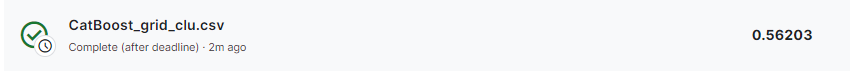

## LightGBM

In [ ]:
lgb_model = lgb.LGBMRegressor(random_state = 42)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = lgb_model.predict(test_clu)
submission['MedHouseVal'] = sub
submission.to_csv('Light_GBM_clu.csv',index = False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6175
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 26
[LightGBM] [Info] Start training from score 2.075544
0.5242772514232051


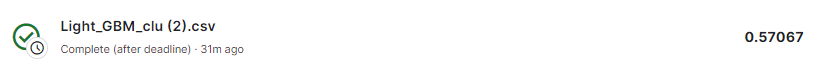

In [ ]:
pd.DataFrame(data = lgb_model.feature_importances_.reshape((1,-1)), columns=X.columns)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,is_generated,coast_0,...,coast_7,coast_8,coast_9,coast_10,coast_11,city_0,city_1,city_2,city_3,city_4
0,353,153,166,110,136,266,247,330,44,33,...,89,42,25,33,54,125,36,44,92,14


## XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)
sub = xgb_model.predict(test_clu)
submission['MedHouseVal'] = sub
submission.to_csv('XGBoost_clu.csv',index = False)

0.5297268711197143


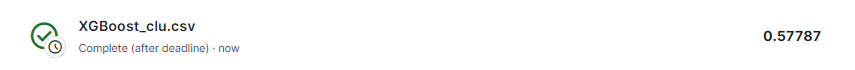

## 앙상블

In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 42)
lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=42)
xgb_model = xgb.XGBRegressor( booster='gbtree', n_jobs=-1,random_state=42)
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)
ef_model = ExtraTreesRegressor(n_jobs=-1, random_state=42)
voting = VotingRegressor(estimators=[('LGB', lgb_model),('XGB',xgb_model),('CAT',cat_model),('RF',rf_model),('EF',ef_model)])
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6175
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 26
[LightGBM] [Info] Start training from score 2.075544
Learning rate set to 0.075028
0:	learn: 1.1068887	total: 15.8ms	remaining: 15.8s
1:	learn: 1.0624099	total: 30.7ms	remaining: 15.3s
2:	learn: 1.0212434	total: 44.9ms	remaining: 14.9s
3:	learn: 0.9833987	total: 59.4ms	remaining: 14.8s
4:	learn: 0.9487025	total: 73.4ms	remaining: 14.6s
5:	learn: 0.9180910	total: 87.8ms	remaining: 14.5s
6:	learn: 0.8891759	total: 103ms	remaining: 14.6s
7:	learn: 0.8641706	total: 118ms	remaining: 14.6s
8:	learn: 0.8407502	total: 132ms	remaining: 14.5s
9:	learn: 0.8204707	total: 146ms	remaining: 14.5s
10:	learn: 0.8022882	total: 161ms	remaining: 14.4s
11:	learn: 0.7855614	total: 174ms	remaining: 14.4s
12:	learn: 0.7696598

0.5121005785137484

In [ ]:
sub = voting.predict(test_clu)
submission['MedHouseVal'] = sub
submission.to_csv('ensemble_clu.csv',index = False)

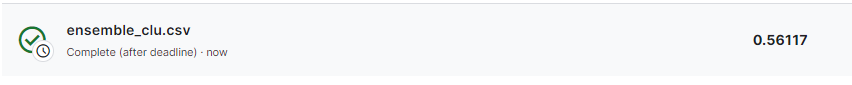

## AUTO ML

In [ ]:
train_clu_copy = train_clu.reset_index(drop=True).copy()


In [ ]:
clf = setup(data      = train_clu_copy,
            target    = 'MedHouseVal',
            verbose   = True,
            train_size= 0.9,
            data_split_shuffle=True,
            session_id= 100,
            normalize = True
            )

,Description,Value
0,Session id,100
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(57777, 27)"
4,Transformed data shape,"(57777, 27)"
5,Transformed train set shape,"(51999, 27)"
6,Transformed test set shape,"(5778, 27)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


In [ ]:
top_5_model = compare_models(fold=10, round=3, sort="rmse", n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.355,0.267,0.516,0.801,0.155,0.197,21.375
lightgbm,Light Gradient Boosting Machine,0.367,0.280,0.529,0.791,0.159,0.205,4.038
et,Extra Trees Regressor,0.360,0.282,0.531,0.789,0.158,0.199,43.717
xgboost,Extreme Gradient Boosting,0.367,0.285,0.534,0.787,0.160,0.203,1.515
rf,Random Forest Regressor,0.369,0.293,0.541,0.781,0.161,0.205,161.343
gbr,Gradient Boosting Regressor,0.399,0.320,0.565,0.761,0.171,0.225,38.347
knn,K Neighbors Regressor,0.450,0.423,0.651,0.684,0.192,0.244,1.868
lr,Linear Regression,0.511,0.493,0.702,0.631,0.211,0.289,1.000
br,Bayesian Ridge,0.511,0.494,0.702,0.631,0.211,0.289,0.247
ridge,Ridge Regression,0.512,0.494,0.703,0.631,0.211,0.290,0.223


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
top_5_model[0]

In [ ]:
tuning_model = tune_model(top_5_model[0],n_iter = 100, optimize = 'rmse')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:54:03
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3606,0.2687,0.5183,0.7982,0.1555,0.2011
1,0.3580,0.2727,0.5222,0.7968,0.1557,0.1945
2,0.3541,0.2644,0.5142,0.8025,0.1554,0.1986
3,0.3513,0.2625,0.5123,0.7979,0.1533,0.1936
4,0.3505,0.2673,0.5170,0.7985,0.1531,0.1922
5,0.3602,0.2795,0.5287,0.7962,0.1579,0.2008
6,0.3575,0.2748,0.5243,0.7921,0.1565,0.1958
7,0.3605,0.2752,0.5246,0.7960,0.1568,0.1993
8,0.3542,0.2655,0.5153,0.7997,0.1564,0.2016


In [ ]:
model = finalize_model( tuning_model )
submission['MedHouseVal'] = predict_model(model, data = test_clu).prediction_label
submission.to_csv('clu_auto_one.csv',index = False)


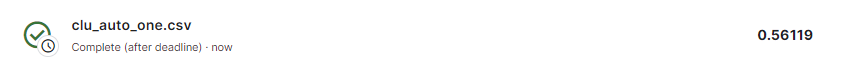

# 주성분 분석

- 위에서 추가한 피처가 많아 차원을 줄이기 위해 주성분 분석을 진행
- 해변까지의 거리는 4개의 피처, 도시는 2개의 피처로 진행

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/멋쟁이/9. 파이널프로젝트/회귀/data/sample_submission.csv')
sklearn_df = pd.DataFrame(fch()['data'], columns=fch()['feature_names'])
sklearn_df['MedHouseVal'] = fch()['target']
train["is_generated"] = True
test["is_generated"] = True
sklearn_df["is_generated"] = False
train_copy = pd.concat([train.drop('id',axis = 1),sklearn_df]).copy()
test_copy = test.copy().drop('id', axis=1)
df = pd.concat([train_copy, test_copy])



# 캘리포니아 주요 해변
coast = np.array([[32.664472968971786, -117.16139777220666],
         [33.20647603453836, -117.38308931734736],
         [33.77719697387153, -118.20238415808473],
         [34.46343131623148, -120.01447157053916],
         [35.42731619324845, -120.8819602254066],
         [35.9284107340049, -121.48920228383551],
         [36.982737132545495, -122.028973002425],
         [37.61147966825591, -122.49163361836126],
         [38.3559871217218, -123.06032062543764],
         [39.79260770260524, -123.82178288918176],
         [40.799744611668416, -124.18805587680554],
         [41.75588735544064, -124.19769463963775]])
city = np.array([[38.576931, -121.494949],
        [37.780080, -122.420160],
        [37.334789, -121.888138],
        [34.052235, -118.243683],
        [32.715759, -117.163818]])
new_df = pd.DataFrame()
def cluster_features_coast(df):
    for i, location in enumerate(coast):
        new_df[f'coast_{i}'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), location, unit='km'), axis=1)
    return new_df
def cluster_features_city(df):
    for i, location in enumerate(city):
        new_df[f'city_{i}'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), location, unit='km'), axis=1)
    return new_df
clu =cluster_features_coast(df)
clu = cluster_features_city(df)

In [ ]:
clu

,coast_0,coast_1,coast_2,coast_3,coast_4,coast_5,coast_6,coast_7,coast_8,coast_9,coast_10,coast_11,city_0,city_1,city_2,city_3,city_4
0,348.320354,296.311313,198.693388,18.001519,115.229477,193.054992,315.962856,396.861046,493.429155,663.833754,776.515090,871.600933,458.920195,409.411859,343.193147,182.746298,344.584492
1,763.524237,700.591149,609.550661,482.130156,364.031429,307.996262,202.694062,163.540022,164.345947,255.398431,345.544480,424.358540,26.989529,145.685572,161.660497,580.385319,758.366057
2,379.848441,328.549280,231.166893,48.386892,88.923506,165.057728,290.022931,371.031975,467.657398,638.985127,752.483183,848.864482,439.964579,384.362181,319.224654,215.271313,376.208630
3,6.702128,66.637929,161.676460,337.078608,465.493307,543.389150,658.808552,737.548173,832.166589,996.127848,1103.344030,1190.264649,768.786647,747.081178,678.914595,188.271295,9.282518
4,743.581815,683.838476,586.477791,428.831566,296.984064,223.649470,96.909469,22.158583,84.036624,253.095040,366.948792,465.617561,117.723106,2.388164,69.220349,560.581242,738.977711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,310.656709,258.095287,160.413728,24.389438,150.664744,228.845060,349.656804,430.242321,526.584527,695.926952,807.723131,901.458816,485.694601,442.073844,375.087815,145.012699,306.834326
24755,174.997502,111.818556,41.350175,193.281161,305.535583,380.879142,488.802620,565.666448,658.813919,820.236317,926.226326,1012.219791,590.802029,573.969175,505.823301,26.464649,169.741830
24756,633.679332,571.467283,478.128151,346.614252,231.630785,185.418689,121.244187,146.897070,217.041162,363.163640,466.446812,553.123853,132.156413,143.188893,95.451535,449.684334,628.667976
24757,135.302046,75.658789,23.771394,207.123360,329.851640,407.049877,520.100818,598.421381,692.785304,856.591121,964.053848,1051.685867,630.244789,607.717523,539.532116,48.982232,130.484863


In [ ]:
coast_scale = clu.iloc[:,:12]
city_scale = clu.iloc[:,12:]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca1 = pca.fit_transform(coast_scale)
pca = PCA(n_components=2)
pca2 = pca.fit_transform(city_scale)


In [ ]:
coast_pca = pd.DataFrame(data=pca1, columns = ['pac1','pac2','pac3','pac4'])
city_pca = pd.DataFrame(data=pca2,  columns = ['pac5','pac6'])


In [ ]:
display(coast_pca.head()), display(city_pca.head())

,pac1,pac2,pac3,pac4
0,-158.718796,-311.134043,81.701840,145.170054
1,964.469759,166.214040,38.884254,-9.197538
2,-71.497468,-322.865086,67.046769,164.613469
3,-1008.700415,314.603505,-150.696018,42.621415
4,1018.225800,-38.389362,-55.007142,-36.319566


,pac5,pac6
0,-93.974693,-52.991718
1,671.107581,77.582423
2,-34.857548,-45.863974
3,-686.426389,204.636253
4,712.256032,-25.839316


(None, None)

In [ ]:
principal = pd.concat([coast_pca,city_pca],axis = 1).reset_index(drop = True)
principal.head()

,pac1,pac2,pac3,pac4,pac5,pac6
0,-158.718796,-311.134043,81.701840,145.170054,-93.974693,-52.991718
1,964.469759,166.214040,38.884254,-9.197538,671.107581,77.582423
2,-71.497468,-322.865086,67.046769,164.613469,-34.857548,-45.863974
3,-1008.700415,314.603505,-150.696018,42.621415,-686.426389,204.636253
4,1018.225800,-38.389362,-55.007142,-36.319566,712.256032,-25.839316


In [ ]:
pca_train = pd.concat([train_copy.reset_index(drop = True),principal.iloc[:57777,:]],axis = 1).reset_index(drop = True)
pca_test = pd.concat([test_copy,principal.iloc[57777:,:]],axis = 1).reset_index(drop=True)
pca_train.shape, pca_test.shape

((57777, 16), (49518, 15))

In [ ]:
pca_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,is_generated,pac1,pac2,pac3,pac4,pac5,pac6
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,True,-158.718796,-311.134043,81.701840,145.170054,-93.974693,-52.991718
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,True,964.469759,166.214040,38.884254,-9.197538,671.107581,77.582423
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,True,-71.497468,-322.865086,67.046769,164.613469,-34.857548,-45.863974
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,True,-1008.700415,314.603505,-150.696018,42.621415,-686.426389,204.636253
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,True,1018.225800,-38.389362,-55.007142,-36.319566,712.256032,-25.839316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57772,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,False,1024.533511,395.001129,95.471925,16.290539,635.887376,236.811669
57773,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,False,1044.413702,397.910751,98.344330,12.657166,644.390234,239.321939
57774,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,False,1040.997464,380.178375,94.219355,9.777224,647.539007,226.821290
57775,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,False,1056.742529,380.638591,95.953248,6.439908,654.544686,227.673172


In [ ]:
X = pca_train.drop('MedHouseVal', axis = 1)
y = pca_train[['MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## 모델생성

In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 42)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = cat_model.predict(pca_test)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_clu_pca.csv',index = False)

Learning rate set to 0.075028
0:	learn: 1.1087079	total: 11.2ms	remaining: 11.2s
1:	learn: 1.0642277	total: 22.5ms	remaining: 11.2s
2:	learn: 1.0244981	total: 35.3ms	remaining: 11.7s
3:	learn: 0.9886183	total: 46.2ms	remaining: 11.5s
4:	learn: 0.9552374	total: 57ms	remaining: 11.3s
5:	learn: 0.9248928	total: 67.9ms	remaining: 11.3s
6:	learn: 0.8969607	total: 78.9ms	remaining: 11.2s
7:	learn: 0.8719498	total: 89.7ms	remaining: 11.1s
8:	learn: 0.8495731	total: 103ms	remaining: 11.3s
9:	learn: 0.8281590	total: 113ms	remaining: 11.2s
10:	learn: 0.8096782	total: 123ms	remaining: 11s
11:	learn: 0.7922854	total: 139ms	remaining: 11.4s
12:	learn: 0.7759558	total: 150ms	remaining: 11.4s
13:	learn: 0.7617779	total: 161ms	remaining: 11.3s
14:	learn: 0.7489046	total: 171ms	remaining: 11.3s
15:	learn: 0.7369613	total: 181ms	remaining: 11.2s
16:	learn: 0.7241610	total: 196ms	remaining: 11.3s
17:	learn: 0.7148710	total: 207ms	remaining: 11.3s
18:	learn: 0.7065729	total: 217ms	remaining: 11.2s
19:	lea

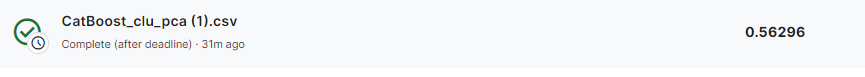

In [ ]:
pd.DataFrame(data = cat_model.feature_importances_.reshape((1,-1)), columns=X.columns)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,is_generated,pac1,pac2,pac3,pac4,pac5,pac6
0,33.737505,3.402739,2.260488,1.075217,1.281025,12.030877,8.937506,7.655229,0.796189,2.18813,6.850057,5.085394,9.199283,0.879555,4.620806


## 모델 생성 (보팅)

In [ ]:
cat_model = catboost.CatBoostRegressor(random_state = 100)
lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=100)
xgb_model = xgb.XGBRegressor( booster='gbtree', n_jobs=-1,random_state=100)
rf_model = RandomForestRegressor(n_jobs=-1, random_state=100)
ef_model = ExtraTreesRegressor(n_jobs=-1, random_state=100)
voting = VotingRegressor(estimators=[('LGB', lgb_model),('XGB',xgb_model),('CAT',cat_model),('RF',rf_model),('EF',ef_model)])
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3370
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 15
[LightGBM] [Info] Start training from score 2.075544
Learning rate set to 0.075028
0:	learn: 1.1075060	total: 22ms	remaining: 21.9s
1:	learn: 1.0623894	total: 50.1ms	remaining: 25s
2:	learn: 1.0220823	total: 80.6ms	remaining: 26.8s
3:	learn: 0.9859779	total: 112ms	remaining: 27.9s
4:	learn: 0.9526218	total: 143ms	remaining: 28.5s
5:	learn: 0.9232807	total: 170ms	remaining: 28.2s
6:	learn: 0.8960740	total: 197ms	remaining: 27.9s
7:	learn: 0.8719157	total: 224ms	remaining: 27.8s
8:	learn: 0.8497480	total: 251ms	remaining: 27.7s
9:	learn: 0.8275037	total: 281ms	remaining: 27.8s
10:	learn: 0.8095140	total: 307ms	remaining: 27.6s
11:	learn: 0.7926289	total: 333ms	remaining: 27.4s
12:	learn: 0.7775106	total:

0.5143355216170827

In [ ]:
sub = voting.predict(pca_test)
submission['MedHouseVal'] = sub
submission.to_csv('ensemble_pca.csv',index = False)

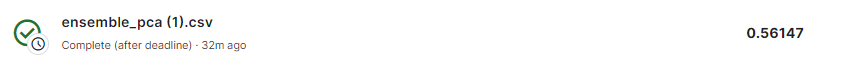

## AUTO ML

In [ ]:
pca_train_copy = pca_train.reset_index(drop=True).copy()


In [ ]:
clf = setup(data      = pca_train_copy,
            target    = 'MedHouseVal',
            verbose   = True,
            train_size= 0.9,
            data_split_shuffle=True,
            session_id= 100,
            normalize = True
            )

,Description,Value
0,Session id,100
1,Target,MedHouseVal
2,Target type,Regression
3,Original data shape,"(57777, 16)"
4,Transformed data shape,"(57777, 16)"
5,Transformed train set shape,"(51999, 16)"
6,Transformed test set shape,"(5778, 16)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [ ]:
top_5_model = compare_models(fold=10, round=3, sort="rmse", n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.356,0.268,0.517,0.800,0.155,0.198,15.198
lightgbm,Light Gradient Boosting Machine,0.368,0.281,0.530,0.790,0.160,0.206,2.334
et,Extra Trees Regressor,0.361,0.282,0.531,0.789,0.158,0.200,25.423
xgboost,Extreme Gradient Boosting,0.368,0.286,0.534,0.787,0.161,0.205,0.898
rf,Random Forest Regressor,0.371,0.294,0.543,0.780,0.162,0.207,82.248
gbr,Gradient Boosting Regressor,0.402,0.323,0.568,0.759,0.172,0.228,20.187
knn,K Neighbors Regressor,0.446,0.418,0.647,0.687,0.191,0.241,2.669
ridge,Ridge Regression,0.529,0.521,0.722,0.611,0.218,0.307,0.203
br,Bayesian Ridge,0.529,0.521,0.722,0.611,0.218,0.307,0.137
lr,Linear Regression,0.529,0.521,0.722,0.611,0.218,0.307,0.718


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
tuning_model = tune_model(top_5_model[0],n_iter = 100, optimize = 'rmse')

In [ ]:
model = finalize_model( tuning_model )
submission['MedHouseVal'] = predict_model(model, data = test_clu).prediction_label
submission.to_csv('clu_pca_auto_one.csv',index = False)


# 주성분 분석 2

- 스케일링을 진행하여 앞서 진행한 주성분 분석과의 차이를 보고자 진행

In [ ]:
train_coast_scale = clu.iloc[:57777,:12]
test_coast_scale = clu.iloc[57777:,:12]
train_city_scale = clu.iloc[:57777,12:]
test_city_scale = clu.iloc[57777:,12:]

In [ ]:
sc = StandardScaler()
train_c = sc.fit_transform(train_coast_scale)
test_c = sc.fit_transform(test_coast_scale)
train_ci = sc.fit_transform(train_city_scale)
test_ci = sc.fit_transform(test_city_scale)
coast_train_df = pd.DataFrame(train_c, columns=train_coast_scale.columns)
coast_test_df = pd.DataFrame(test_c, columns=test_coast_scale.columns)
city_train_df = pd.DataFrame(train_ci, columns=train_city_scale.columns)
city_test_df = pd.DataFrame(test_ci, columns=test_city_scale.columns)


In [ ]:
coast_sc = pd.concat([coast_train_df,coast_test_df], axis = 0)
city_sc = pd.concat([city_train_df,city_test_df], axis = 0)

In [ ]:
pca = PCA(n_components=4)
pca1 = pca.fit_transform(coast_sc)
pca = PCA(n_components=2)
pca2 = pca.fit_transform(city_sc)

In [ ]:
principalDf = pd.DataFrame(data=pca1, columns = ['pac1','pac2','pac3','pac4'])
city2 = pd.DataFrame(data=pca2, columns = ['pac5','pac6'])
pac_asd = pd.concat([principalDf,city2], axis = 1)
pac_asd

,pac1,pac2,pac3,pac4,pac5,pac6
0,-0.521198,-3.120285,0.610302,0.468447,0.351381,-0.234979
1,3.607962,1.310869,0.199614,-0.018632,-2.624101,0.342490
2,-0.099657,-3.333017,0.520180,0.646935,0.116523,-0.207102
3,-4.040213,2.372442,-0.562007,0.278936,2.721611,0.851578
4,4.032172,0.022998,-0.217838,-0.175529,-2.838644,-0.088824
...,...,...,...,...,...,...
82531,-0.991153,-2.741382,0.610723,0.334920,0.662850,-0.244520
82532,-2.502955,-0.267997,0.096033,-0.105537,1.776301,-0.196390
82533,2.931780,-1.026144,-0.098150,0.190723,-2.115716,-0.258513
82534,-2.911495,0.087247,0.001699,-0.143999,1.998406,-0.024049


In [ ]:
pac_train = pac_asd.iloc[:57777,:]
pac_test = pac_asd.iloc[57777:,:]
pac_train.shape, pac_test.shape, display(pac_train.head())

,pac1,pac2,pac3,pac4,pac5,pac6
0,-0.521198,-3.120285,0.610302,0.468447,0.351381,-0.234979
1,3.607962,1.310869,0.199614,-0.018632,-2.624101,0.342490
2,-0.099657,-3.333017,0.520180,0.646935,0.116523,-0.207102
3,-4.040213,2.372442,-0.562007,0.278936,2.721611,0.851578
4,4.032172,0.022998,-0.217838,-0.175529,-2.838644,-0.088824


((57777, 6), (24759, 6), None)

In [ ]:
pca_train = pd.concat([train_copy.reset_index(drop = True),pac_train.reset_index(drop = True)],axis = 1)
pca_test = pd.concat([test_copy,pac_test.reset_index(drop=True)],axis = 1)
pca_train.shape, pca_test.shape

((57777, 16), (24759, 15))

In [ ]:
X = pca_train.drop('MedHouseVal', axis = 1)
y = pca_train[['MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## 모델생성

In [ ]:
cat_model = catboost.CatBoostRegressor()
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
sub = cat_model.predict(pca_test)
submission['MedHouseVal'] = sub
submission.to_csv('CatBoost_clu_pca2.csv',index = False)

Learning rate set to 0.075028
0:	learn: 1.1094334	total: 12.9ms	remaining: 12.9s
1:	learn: 1.0636797	total: 23.6ms	remaining: 11.8s
2:	learn: 1.0216652	total: 34.5ms	remaining: 11.5s
3:	learn: 0.9852641	total: 44.9ms	remaining: 11.2s
4:	learn: 0.9524063	total: 55.6ms	remaining: 11.1s
5:	learn: 0.9228497	total: 66.3ms	remaining: 11s
6:	learn: 0.8963238	total: 76.7ms	remaining: 10.9s
7:	learn: 0.8698307	total: 87.1ms	remaining: 10.8s
8:	learn: 0.8457932	total: 111ms	remaining: 12.2s
9:	learn: 0.8240611	total: 123ms	remaining: 12.2s
10:	learn: 0.8049549	total: 134ms	remaining: 12s
11:	learn: 0.7865912	total: 146ms	remaining: 12s
12:	learn: 0.7719866	total: 159ms	remaining: 12.1s
13:	learn: 0.7569077	total: 170ms	remaining: 12s
14:	learn: 0.7436370	total: 180ms	remaining: 11.8s
15:	learn: 0.7312583	total: 195ms	remaining: 12s
16:	learn: 0.7211319	total: 207ms	remaining: 12s
17:	learn: 0.7107414	total: 218ms	remaining: 11.9s
18:	learn: 0.6999130	total: 228ms	remaining: 11.8s
19:	learn: 0.69

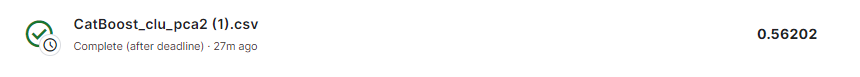

In [ ]:
cat_model = catboost.CatBoostRegressor()
lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=100)
xgb_model = xgb.XGBRegressor( booster='gbtree', n_jobs=-1,random_state=100)
rf_model = RandomForestRegressor(n_jobs=-1, random_state=100)
ef_model = ExtraTreesRegressor(n_jobs=-1, random_state=100)
voting = VotingRegressor(estimators=[('LGB', lgb_model),('XGB',xgb_model),('CAT',cat_model),('RF',rf_model),('EF',ef_model)])
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3370
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 15
[LightGBM] [Info] Start training from score 2.075544
Learning rate set to 0.075028
0:	learn: 1.1094334	total: 10.6ms	remaining: 10.6s
1:	learn: 1.0636797	total: 21.6ms	remaining: 10.8s
2:	learn: 1.0216652	total: 32.3ms	remaining: 10.7s
3:	learn: 0.9852641	total: 42.5ms	remaining: 10.6s
4:	learn: 0.9524063	total: 54.9ms	remaining: 10.9s
5:	learn: 0.9228497	total: 65.5ms	remaining: 10.8s
6:	learn: 0.8963238	total: 79.7ms	remaining: 11.3s
7:	learn: 0.8698307	total: 90.1ms	remaining: 11.2s
8:	learn: 0.8457932	total: 104ms	remaining: 11.5s
9:	learn: 0.8240611	total: 115ms	remaining: 11.4s
10:	learn: 0.8049549	total: 126ms	remaining: 11.3s
11:	learn: 0.7865912	total: 137ms	remaining: 11.3s
12:	learn: 0.77198

0.5135677403896096

In [ ]:
sub = voting.predict(pca_test)
submission['MedHouseVal'] = sub
submission.to_csv('ensemble_pca2.csv',index = False)

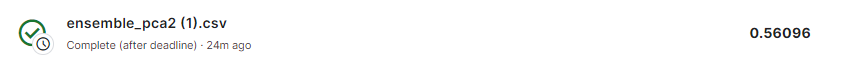

## AUTO ML

In [ ]:
pca_X = pca_train.reset_index(drop = True).copy()

In [ ]:
clf = setup(data      = pca_X,
            target    = 'MedHouseVal',
            verbose   = True,
            train_size= 0.9,
            data_split_shuffle=True,
            session_id= 100,
            normalize = True
            )

In [ ]:
top_5_model = compare_models(fold=10, round=3, sort="rmse", n_select=5)

In [ ]:
tuning_model = tune_model(top_5_model[0],n_iter = 100, optimize = 'rmse')

In [ ]:
model = finalize_model( tuning_model )
submission['MedHouseVal'] = predict_model(model, data = test_clu).prediction_label
submission.to_csv('clu_pca2_auto_one.csv',index = False)


In [ ]:
blended = blend_models(estimator_list=top_5_model,
             fold   = 10,
             optimize='rmse'
             )

In [ ]:
model = finalize_model( blended )
submission['MedHouseVal'] = predict_model(model, data = test_clu)
submission.to_csv('clu_pca2_auto_blended5.csv',index = False)

In [ ]:
blended3 = blend_models(estimator_list=top_5_model[:3],
             fold   = 10,
             optimize='rmse'
             )

In [ ]:
model = finalize_model( blended3 )
submission['MedHouseVal'] = predict_model(model, data = test_clu)
submission.to_csv('clu_pca2_auto_blended3.csv',index = False)

In [ ]:
pca = pd.concat([pca_train,pca_test],axis = 0 )
pca

In [ ]:
location = pca[['Latitude', 'Longitude']].values
clustering = KMeans(n_clusters=20,
                    max_iter=1111,
                    random_state=228).fit(location)

cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
def cluster_features(df):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), cc, unit='ft'), axis=1)
    return df
pca_all = cluster_features(pca)

In [ ]:
pac_train = pca_all.iloc[:57777,:]
pac_test = pca_all.iloc[57777:,:].drop('MedHouseVal',axis = 1)
pac_train.shape, pac_test.shape, display(pac_train.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,is_generated,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,True,...,3.643474e+05,1.191752e+06,1.634947e+06,2.350737e+05,7.327605e+05,5.758265e+05,1.319434e+06,4.623823e+05,2.281066e+06,1.308908e+06
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,True,...,1.748849e+06,3.355754e+05,4.335890e+05,1.317201e+06,1.536939e+06,1.889299e+06,4.661025e+05,1.308878e+06,7.618171e+05,2.429467e+06
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,True,...,4.711672e+05,1.133734e+06,1.555511e+06,1.535869e+05,8.093911e+05,6.825642e+05,1.238294e+06,5.088772e+05,2.218082e+06,1.415175e+06
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,True,...,8.172828e+05,2.208052e+06,2.725387e+06,1.388036e+06,1.036555e+06,6.354635e+05,2.424046e+06,1.208361e+06,3.272462e+06,4.686945e+05
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,True,...,1.643424e+06,3.940437e+05,2.925856e+05,1.115360e+06,1.583400e+06,1.820115e+06,3.124242e+04,1.278304e+06,1.029736e+06,2.456651e+06


((57777, 36), (24759, 35), None)

In [ ]:
X = pac_train.drop('MedHouseVal', axis = 1)
y = pac_train[['MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [ ]:
cat_model = catboost.CatBoostRegressor(verbose=False)
lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=100, )
xgb_model = xgb.XGBRegressor( booster='gbtree', n_jobs=-1,random_state=100)
rf_model = RandomForestRegressor(n_jobs=-1, random_state=100)
ef_model = ExtraTreesRegressor(n_jobs=-1, random_state=100)
voting = VotingRegressor(estimators=[('LGB', lgb_model),('XGB',xgb_model),('CAT',cat_model),('RF',rf_model),('EF',ef_model)])
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8470
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 35
[LightGBM] [Info] Start training from score 2.075544


0.5109086255371765

In [ ]:
sub = voting.predict(pac_test)
submission['MedHouseVal'] = sub
submission.to_csv('ensemble_pca_clu.csv',index = False)

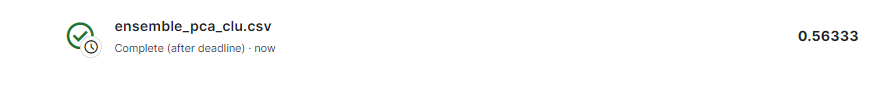

# 로케이션 추가

- 모델의 성능이 원하는 만큼 나오지 않아 discussion에 있는 로테이션 변수 추가
- 로테이션 변수 : 원점 좌표를 기준으로 15도와 30도를 회전시킴

In [ ]:
!pip install reverse_geocoder

In [ ]:
import reverse_geocoder as rg

In [ ]:
pca_all = pd.concat([pca_train, pca_test],axis = 0)
pca_all

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,is_generated,pac1,pac2,pac3,pac4,pac5,pac6
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,True,-0.521198,-3.120285,0.610302,0.468447,0.351381,-0.234979
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,True,3.607962,1.310869,0.199614,-0.018632,-2.624101,0.342490
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,True,-0.099657,-3.333017,0.520180,0.646935,0.116523,-0.207102
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,True,-4.040213,2.372442,-0.562007,0.278936,2.721611,0.851578
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,True,4.032172,0.022998,-0.217838,-0.175529,-2.838644,-0.088824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,2.2875,34.0,3.914729,1.085271,866.0,2.071429,34.44,-119.75,NaN,True,-0.991153,-2.741382,0.610723,0.334920,0.662850,-0.244520
24755,3.0781,33.0,4.771971,1.038674,1628.0,2.326848,34.09,-117.96,NaN,True,-2.502955,-0.267997,0.096033,-0.105537,1.776301,-0.196390
24756,2.6961,14.0,4.593960,1.170380,3900.0,2.540034,37.51,-120.83,NaN,True,2.931780,-1.026144,-0.098150,0.190723,-2.115716,-0.258513
24757,7.2315,8.0,7.508403,1.018692,1388.0,2.601202,33.67,-117.98,NaN,True,-2.911495,0.087247,0.001699,-0.143999,1.998406,-0.024049


In [ ]:
def rotx(df, angle):
    return (np.cos(np.radians(angle)) * df['Longitude']) - (np.sin(np.radians(angle)) * df['Latitude'])

def roty(df, angle):
    return (np.sin(np.radians(angle)) * df['Longitude']) + (np.cos(np.radians(angle)) * df['Latitude'])

def add_rotation_features(df):

    df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                      (np.sin(np.radians(15)) * df['Latitude'])

    df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                      (np.sin(np.radians(30)) * df['Latitude'])

    df['rot_45_x'] = (np.cos(np.radians(45)) * df['Longitude']) + \
                      (np.sin(np.radians(45)) * df['Latitude'])

add_rotation_features(pca_all)

In [ ]:
pca_all

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,is_generated,pac1,pac2,pac3,pac4,pac5,pac6,rot_15_x,rot_30_x,rot_45_x
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,True,-0.521198,-3.120285,0.610302,0.468447,0.351381,-0.234979,-107.071871,-86.726972,-60.471772
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,True,3.607962,1.310869,0.199614,-0.018632,-2.624101,0.342490,-107.075820,-85.634599,-58.357523
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,True,-0.099657,-3.333017,0.520180,0.646935,0.116523,-0.207102,-107.362157,-86.957760,-60.627335
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,True,-4.040213,2.372442,-0.562007,0.278936,2.721611,0.851578,-104.647225,-85.072915,-59.701026
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,True,4.032172,0.022998,-0.217838,-0.175529,-2.838644,-0.088824,-108.455620,-87.110170,-59.828305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,2.2875,34.0,3.914729,1.085271,866.0,2.071429,34.44,-119.75,NaN,True,-0.991153,-2.741382,0.610723,0.334920,0.662850,-0.244520,-106.755890,-86.486542,-60.323280
24755,3.0781,33.0,4.771971,1.038674,1628.0,2.326848,34.09,-117.96,NaN,True,-2.502955,-0.267997,0.096033,-0.105537,1.776301,-0.196390,-105.117469,-85.111357,-59.305046
24756,2.6961,14.0,4.593960,1.170380,3900.0,2.540034,37.51,-120.83,NaN,True,2.931780,-1.026144,-0.098150,0.190723,-2.115716,-0.258513,-107.004515,-85.886850,-58.916137
24757,7.2315,8.0,7.508403,1.018692,1388.0,2.601202,33.67,-117.98,NaN,True,-2.911495,0.087247,0.001699,-0.143999,1.998406,-0.024049,-105.245492,-85.338677,-59.616173


In [ ]:
pac_train = pca_all.iloc[:57777,:]
pac_test = pca_all.iloc[57777:,:].drop('MedHouseVal',axis = 1)
pac_train.shape, pac_test.shape, display(pac_train.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,is_generated,pac1,pac2,pac3,pac4,pac5,pac6,rot_15_x,rot_30_x,rot_45_x
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,True,-0.521198,-3.120285,0.610302,0.468447,0.351381,-0.234979,-107.071871,-86.726972,-60.471772
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,True,3.607962,1.310869,0.199614,-0.018632,-2.624101,0.342490,-107.075820,-85.634599,-58.357523
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,True,-0.099657,-3.333017,0.520180,0.646935,0.116523,-0.207102,-107.362157,-86.957760,-60.627335
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,True,-4.040213,2.372442,-0.562007,0.278936,2.721611,0.851578,-104.647225,-85.072915,-59.701026
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,True,4.032172,0.022998,-0.217838,-0.175529,-2.838644,-0.088824,-108.455620,-87.110170,-59.828305


((57777, 19), (24759, 18), None)

In [ ]:
X = pac_train.drop('MedHouseVal', axis = 1)
y = pac_train[['MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [ ]:
cat_model = catboost.CatBoostRegressor(verbose=False)
lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=100, )
xgb_model = xgb.XGBRegressor( booster='gbtree', n_jobs=-1,random_state=100)
rf_model = RandomForestRegressor(n_jobs=-1, random_state=100)
ef_model = ExtraTreesRegressor(n_jobs=-1, random_state=100)
voting = VotingRegressor(estimators=[('LGB', lgb_model),('XGB',xgb_model),('CAT',cat_model),('RF',rf_model),('EF',ef_model)])
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))
sub = voting.predict(pac_test)
submission['MedHouseVal'] = sub
submission.to_csv('ensemble_pca_clu_location.csv',index = False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4135
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 18
[LightGBM] [Info] Start training from score 2.075544


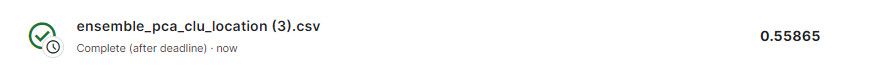

In [ ]:
cat_model = catboost.CatBoostRegressor(verbose=False)
lgb_model = lgb.LGBMRegressor()
xgb_model = xgb.XGBRegressor()
rf_model = RandomForestRegressor()
ef_model = ExtraTreesRegressor()
voting = VotingRegressor(estimators=[('LGB', lgb_model),('XGB',xgb_model),('CAT',cat_model),('RF',rf_model),('EF',ef_model)])
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))
sub = voting.predict(pac_test)
submission['MedHouseVal'] = sub
submission.to_csv('ensemble_pca_clu_location2.csv',index = False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4135
[LightGBM] [Info] Number of data points in the train set: 46221, number of used features: 18
[LightGBM] [Info] Start training from score 2.075544
